In [131]:
import time
import os
from sklearn.model_selection import train_test_split
import cv2
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns

# Haar Classification

In [132]:
face_cascade = cv2.CascadeClassifier(f"../../data/haar_clasifier/haarcascade_frontalface_default.xml")

def detect_face(img, cascade=face_cascade, scalefactor=1.2, minNeighbours=8):
    
    face_img = img.copy()
    face_rect = cascade.detectMultiScale(face_img, scaleFactor = scalefactor, minNeighbors = minNeighbours)
     
    for (x, y, w, h) in face_rect:
        cv2.rectangle(face_img, (x, y), 
                      (x + w, y + h), (255, 0, 255), 10)\
         
    return face_img



# Eigenface

In [133]:
def load_images_from_folder(folder_path, label, image_size=(325, 288)):
    images = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.jpg'):
            path = os.path.join(folder_path, filename)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, image_size)
                images.append(img)
                labels.append(label)
    return images, labels

me_imgs, me_labels = load_images_from_folder('../../data/complex/me', label=0)
face_imgs, face_labels = load_images_from_folder('../../data/complex/images_of_face', label=1)

all_images = me_imgs + face_imgs
all_labels = me_labels + face_labels


In [134]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.33, stratify=all_labels, random_state=42
)


In [135]:
def evaluate_model(model, images, labels, threshold):
    correct = false = unrecognized = 0
    confidences = []

    for img, true_label in zip(images, labels):
        predicted_label, confidence = model.predict(img)
        if confidence > threshold:
            unrecognized += 1
        elif predicted_label == true_label:
            correct += 1
            confidences.append(confidence)
        else:
            false += 1
            confidences.append(confidence)

    return correct, false, unrecognized, confidences


In [136]:
def run_eigenface_experiment(train_imgs, train_labels, test_imgs, test_labels, num_components_list, threshholds):
    results = []

    for num_components in num_components_list:
            for threshold in threshholds:
                model = cv2.face.EigenFaceRecognizer_create(num_components=num_components, threshold=threshold)
                model.train(train_imgs, np.array(train_labels))

                correct, false, unrecognized, confidences = evaluate_model(model, test_imgs, test_labels, threshold)

                result = {
                    "num_components": num_components,
                    "threshold": threshold,
                    "correct": correct,
                    "false": false,
                    "unrecognized": unrecognized,
                    "min_conf": np.min(confidences) if confidences else None,
                    "max_conf": np.max(confidences) if confidences else None,
                    "mean_conf": np.mean(confidences) if confidences else None,
                    "std_conf": st.stdev(confidences) if len(confidences) > 1 else None
                }
                results.append(result)

                print(result)

                if correct >= max(result['correct'] for result in results):  
                    sample_img = test_imgs[0]
                    predicted_label, confidence = model.predict(sample_img)
                    label_text = f"Predicted: {predicted_label}, Conf: {int(confidence)}"

                    img = detect_face(sample_img)
                    cv2.putText(
                        img,
                        label_text,
                        org=(10, 30),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.5,
                        color=(255, 0, 0)
                    )
                    img_path = f"../../data/complex/classified/eigenface_nc:{num_components}_th:{threshold}_cf:{confidence}.jpg"
                    cv2.imwrite(img_path, img)

    return results, model


In [ ]:
num_components_list = [80, 100, 150, 200, 250]
threshold_list = [100000]
results, _ = run_eigenface_experiment(train_imgs, train_labels, test_imgs, test_labels, num_components_list, threshold_list)
df_results = pd.DataFrame(results)

x = [r['num_components'] for r in results]
y = [r['mean_conf'] for r in results]
yerr = [r['std_conf'] if r['std_conf'] is not None else 0 for r in results]

plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, label='Confidence ± Std Dev')
plt.title('Mean Confidence vs. num_components (Eigenfaces)')
plt.xlabel('num_components')
plt.ylabel('Confidence')
plt.grid()
plt.legend()
plt.show()


{'num_components': 200, 'threshold': 5000, 'correct': 61, 'false': 0, 'unrecognized': 38, 'min_conf': np.float64(224.11020040922662), 'max_conf': np.float64(4896.417188890919), 'mean_conf': np.float64(2544.079749098387), 'std_conf': 1284.1650001515866}
{'num_components': 200, 'threshold': 10000, 'correct': 90, 'false': 3, 'unrecognized': 6, 'min_conf': np.float64(224.11020040922662), 'max_conf': np.float64(9892.101971409442), 'mean_conf': np.float64(4245.130653262609), 'std_conf': 2741.3361979386264}
{'num_components': 200, 'threshold': 15000, 'correct': 96, 'false': 3, 'unrecognized': 0, 'min_conf': np.float64(224.11020040922662), 'max_conf': np.float64(13217.721239099134), 'mean_conf': np.float64(4707.261071796032), 'std_conf': 3231.0240234077387}
{'num_components': 200, 'threshold': 20000, 'correct': 96, 'false': 3, 'unrecognized': 0, 'min_conf': np.float64(224.11020040922662), 'max_conf': np.float64(13217.721239099134), 'mean_conf': np.float64(4707.261071796032), 'std_conf': 3231.0

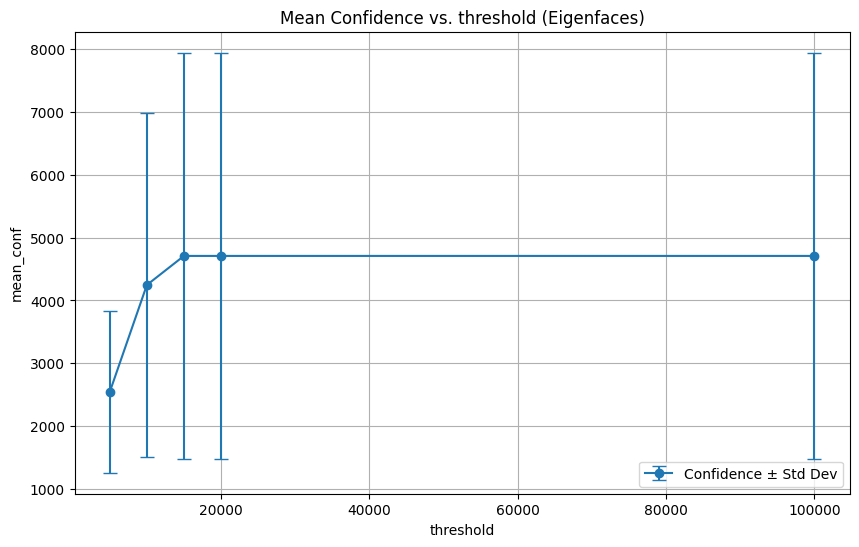

In [ ]:
num_components_list = [200]
threshold_list = [5000, 10000, 15000, 20000, 100000]
results, eigenface_model = run_eigenface_experiment(train_imgs, train_labels, test_imgs, test_labels, num_components_list, threshold_list)
df_results = pd.concat([df_results, pd.DataFrame(results)], axis=0)

x = [r['threshold'] for r in results]
y = [r['mean_conf'] for r in results]
yerr = [r['std_conf'] if r['std_conf'] is not None else 0 for r in results]

plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, label='Confidence ± Std Dev')
plt.title('Mean Confidence vs. threshold (Eigenfaces)')
plt.xlabel('threshold')
plt.ylabel('mean_conf')
plt.grid()
plt.legend()
plt.show()


In [111]:
df_results

,num_components,threshold,correct,false,unrecognized,min_conf,max_conf,mean_conf,std_conf
0,80,100000,98,1,0,165.764900,12448.658965,3965.296597,3183.931344
1,100,100000,97,2,0,176.545649,12595.383856,4161.291150,3253.483613
2,150,100000,96,3,0,204.934537,13069.263182,4563.556242,3262.132757
3,200,100000,96,3,0,224.110200,13217.721239,4707.261072,3231.024023
4,250,100000,96,3,0,224.289490,13217.807479,4711.320787,3232.664108
0,200,5000,61,0,38,224.110200,4896.417189,2544.079749,1284.165000
1,200,10000,90,3,6,224.110200,9892.101971,4245.130653,2741.336198
2,200,15000,96,3,0,224.110200,13217.721239,4707.261072,3231.024023
3,200,20000,96,3,0,224.110200,13217.721239,4707.261072,3231.024023
4,200,100000,96,3,0,224.110200,13217.721239,4707.261072,3231.024023


# Fisherface

In [112]:
def run_fisherface_experiment(images, labels, num_components, threshold):
    results = []
    
    for i in range(5):
                train_imgs, test_imgs, train_labels, test_labels = train_test_split(
                all_images, all_labels, test_size=0.33, stratify=all_labels
                )

                
                model = cv2.face.FisherFaceRecognizer_create(num_components=num_components, threshold=threshold)
                model.train(train_imgs, np.array(train_labels))

                correct, false, unrecognized, confidences = evaluate_model(model, test_imgs, test_labels, threshold)

                result = {
                    "repetition": i,
                    "num_components": num_components,
                    "threshold": threshold,
                    "correct": correct,
                    "false": false,
                    "unrecognized": unrecognized,
                    "min_conf": np.min(confidences) if confidences else None,
                    "max_conf": np.max(confidences) if confidences else None,
                    "mean_conf": np.mean(confidences) if confidences else None,
                    "std_conf": st.stdev(confidences) if len(confidences) > 1 else None
                }
                results.append(result)

                print(result)

                if correct >= max(result['correct'] for result in results):  
                    sample_img = test_imgs[0]
                    predicted_label, confidence = model.predict(sample_img)
                    label_text = f"Predicted: {predicted_label}, Conf: {int(confidence)}"

                    img = detect_face(sample_img)
                    cv2.putText(
                        img,
                        label_text,
                        org=(10, 30),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.5,
                        color=(255, 0, 0)
                    )
                    img_path = f"../../data/complex/classified/fisherface_nc:{num_components}_th:{threshold}_cf:{confidence}.jpg"
                    cv2.imwrite(img_path, img)

    return results, model

{'repetition': 0, 'num_components': 1, 'threshold': 100000, 'correct': 94, 'false': 5, 'unrecognized': 0, 'min_conf': np.float64(0.08984136169624435), 'max_conf': np.float64(2646.2686069074744), 'mean_conf': np.float64(225.09476023956228), 'std_conf': 359.4191948217422}
{'repetition': 1, 'num_components': 1, 'threshold': 100000, 'correct': 98, 'false': 1, 'unrecognized': 0, 'min_conf': np.float64(0.1918033479969381), 'max_conf': np.float64(2327.107807534916), 'mean_conf': np.float64(213.46173617579288), 'std_conf': 343.91674114801646}
{'repetition': 2, 'num_components': 1, 'threshold': 100000, 'correct': 99, 'false': 0, 'unrecognized': 0, 'min_conf': np.float64(0.22941951825453089), 'max_conf': np.float64(2178.3024452210093), 'mean_conf': np.float64(205.15484432856488), 'std_conf': 322.64327447738685}
{'repetition': 3, 'num_components': 1, 'threshold': 100000, 'correct': 98, 'false': 1, 'unrecognized': 0, 'min_conf': np.float64(0.3045624621111074), 'max_conf': np.float64(2050.934952869

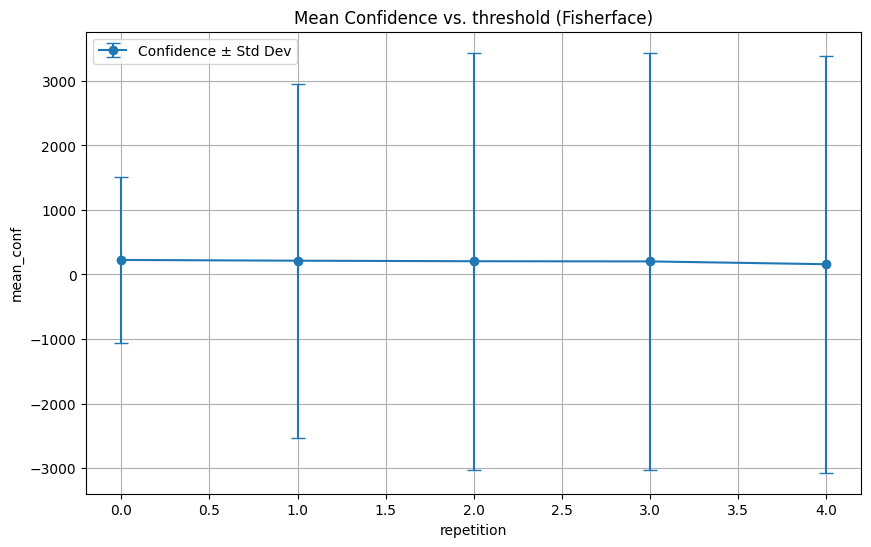

In [ ]:
thresholds = 100000
num_components_list = 1
fisher_results, fishface_model = run_fisherface_experiment(all_images, all_labels, num_components_list, thresholds)

fisher_df = pd.DataFrame(fisher_results)

x = [r["repetition"] for r in fisher_results]
y = [r['mean_conf'] for r in fisher_results]
yerr = [r['std_conf'] if r['std_conf'] is not None else 0 for r in results]

plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, label='Confidence ± Std Dev')
plt.title('Mean Confidence vs. threshold (Fisherface)')
plt.xlabel("repetition")
plt.ylabel('mean_conf')
plt.grid()
plt.legend()
plt.show()


In [114]:
fisher_df

,repetition,num_components,threshold,correct,false,unrecognized,min_conf,max_conf,mean_conf,std_conf
0,0,1,100000,94,5,0,0.089841,2646.268607,225.094760,359.419195
1,1,1,100000,98,1,0,0.191803,2327.107808,213.461736,343.916741
2,2,1,100000,99,0,0,0.229420,2178.302445,205.154844,322.643274
3,3,1,100000,98,1,0,0.304562,2050.934953,202.437766,301.518694
4,4,1,100000,98,1,0,0.150966,780.837604,158.960139,180.639478


# Local Binary Pattern

In [115]:
def run_lbph_experiment(train_imgs, train_labels, test_imgs, test_labels, radius_list, grid_list, threshold, neighbors=8):
    results = []

    for radius in radius_list:
        for grid in grid_list:
            model = cv2.face.LBPHFaceRecognizer_create(radius=radius, neighbors=neighbors, grid_x=grid, grid_y=grid, threshold=threshold)
            model.train(train_imgs, np.array(train_labels))

            correct, false, unrecognized, confidences = evaluate_model(model, test_imgs, test_labels, threshold)

            result = {
                "radius": radius,
                "grid": grid,
                "threshold": threshold,
                "neighbors": neighbors,
                "correct": correct,
                "false": false,
                "unrecognized": unrecognized,
                "min_conf": np.min(confidences) if confidences else None,
                "max_conf": np.max(confidences) if confidences else None,
                "mean_conf": np.mean(confidences) if confidences else None,
                "std_conf": st.stdev(confidences) if len(confidences) > 1 else None
            }
            results.append(result)

            print(result)

            # Save best-performing image
            if correct >= max(r["correct"] for r in results):
                sample_img = test_imgs[0]
                predicted_label, confidence = model.predict(sample_img)

                label_text = f"Pred: {predicted_label}, Conf: {int(confidence)}"
                annotated_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2BGR)
                cv2.putText(annotated_img, label_text, (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

                os.makedirs("../../data/complex/classified", exist_ok=True)
                save_path = f"../../data/complex/classified/lbph_r{radius}_g{grid}_t{threshold}.jpg"
                cv2.imwrite(save_path, annotated_img)

    return results, model


In [ ]:
radius_list = [1, 3, 6, 9, 15]
grid_list = [1, 3, 6, 9, 15]
threshold = 100000  # Fixed as in the previous experiments

lbph_results, lbph_model = run_lbph_experiment(train_imgs, train_labels, test_imgs, test_labels, radius_list, grid_list, threshold)

lbph_df = pd.DataFrame(lbph_results)
print(lbph_df)


{'radius': 1, 'grid': 1, 'threshold': 100000, 'neighbors': 8, 'correct': 99, 'false': 0, 'unrecognized': 0, 'min_conf': np.float64(0.005196844620944833), 'max_conf': np.float64(0.08439784163776075), 'mean_conf': np.float64(0.014444631815307283), 'std_conf': 0.010895404414272713}
{'radius': 1, 'grid': 3, 'threshold': 100000, 'neighbors': 8, 'correct': 99, 'false': 0, 'unrecognized': 0, 'min_conf': np.float64(0.36757764657230063), 'max_conf': np.float64(2.845945908011124), 'mean_conf': np.float64(0.9606038362217769), 'std_conf': 0.5103550015463725}
{'radius': 1, 'grid': 6, 'threshold': 100000, 'neighbors': 8, 'correct': 99, 'false': 0, 'unrecognized': 0, 'min_conf': np.float64(4.538089595477569), 'max_conf': np.float64(23.39918801237045), 'mean_conf': np.float64(9.952448453084632), 'std_conf': 4.177652999457812}
{'radius': 1, 'grid': 9, 'threshold': 100000, 'neighbors': 8, 'correct': 99, 'false': 0, 'unrecognized': 0, 'min_conf': np.float64(17.809273912079775), 'max_conf': np.float64(72.

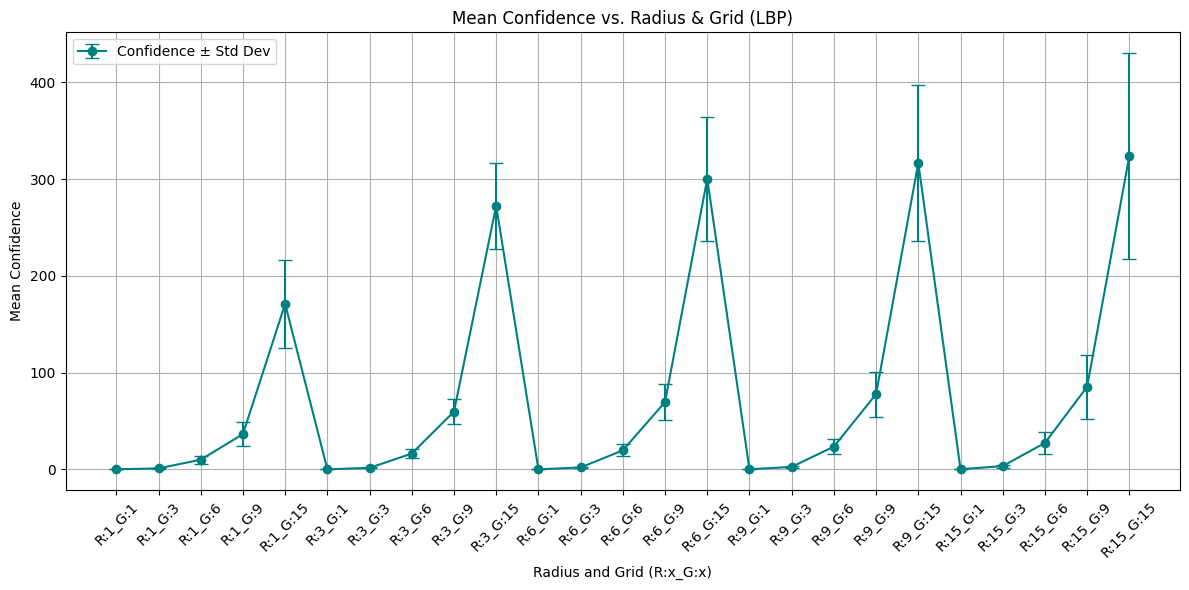

In [122]:
lbph_df['label'] = lbph_df.apply(lambda row: f"R:{row['radius']}_G:{row['grid']}", axis=1)

x = lbph_df['label']
y = lbph_df['mean_conf']
yerr = lbph_df['std_conf'].fillna(0)

plt.figure(figsize=(12, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o-', capsize=5, label='Confidence ± Std Dev', color='teal')
plt.title('Mean Confidence vs. Radius & Grid (LBP)')
plt.xlabel("Radius and Grid (R:x_G:x)")
plt.ylabel('Mean Confidence')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [123]:
lbph_df

,radius,grid,threshold,neighbors,correct,false,unrecognized,min_conf,max_conf,mean_conf,std_conf,label
0,1,1,100000,8,99,0,0,0.005197,0.084398,0.014445,0.010895,R:1_G:1
1,1,3,100000,8,99,0,0,0.367578,2.845946,0.960604,0.510355,R:1_G:3
2,1,6,100000,8,99,0,0,4.538090,23.399188,9.952448,4.177653,R:1_G:6
3,1,9,100000,8,99,0,0,17.809274,72.045877,36.397260,12.663479,R:1_G:9
4,1,15,100000,8,99,0,0,95.469022,275.903509,171.069662,45.153221,R:1_G:15
5,3,1,100000,8,99,0,0,0.009808,0.136572,0.022074,0.014477,R:3_G:1
6,3,3,100000,8,99,0,0,0.816946,4.217092,1.512234,0.565196,R:3_G:3
7,3,6,100000,8,99,0,0,9.645725,28.879446,16.290762,4.329657,R:3_G:6
8,3,9,100000,8,99,0,0,37.291220,93.230721,59.659310,12.835526,R:3_G:9
9,3,15,100000,8,99,0,0,186.244499,362.319635,272.469969,44.445270,R:3_G:15


# Combination of Classifications

In [118]:
def recognize_multiple_faces(model, img, method_name, img_num):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(img, 1.1, 5)

    for (x, y, w, h) in faces:
        face_roi = img[y:y+h, x:x+w]
        resized_face = cv2.resize(face_roi, (288, 325))
        predicted_label, confidence = model.predict(resized_face)

        label_str = f"{predicted_label}, Conf: {int(confidence)}"
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img, label_str, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    title = f"{method_name}_{img_num}.jpg"
    out_path = f"../../data/complex/me_and_face/classified/{title}"
    cv2.imwrite(out_path, img)
    print(f"Saved: {out_path}")


In [119]:
us_imgs, _ = load_images_from_folder('../../data/complex/me_and_face', label=0)

for i in range(len(us_imgs)):
    recognize_multiple_faces(model=eigenface_model, img=us_imgs[i],method_name="Eigenfaces", img_num=i+1) 
    recognize_multiple_faces(model=fishface_model, img=us_imgs[i],method_name="Fisherface", img_num=i+1) 
    recognize_multiple_faces(model=lbph_model, img=us_imgs[i],method_name="LBP", img_num=i+1) 

Saved: ../../data/complex/me_and_face/classified/Eigenfaces_1.jpg
Saved: ../../data/complex/me_and_face/classified/Fisherface_1.jpg
Saved: ../../data/complex/me_and_face/classified/LBP_1.jpg
Saved: ../../data/complex/me_and_face/classified/Eigenfaces_2.jpg
Saved: ../../data/complex/me_and_face/classified/Fisherface_2.jpg
Saved: ../../data/complex/me_and_face/classified/LBP_2.jpg
Saved: ../../data/complex/me_and_face/classified/Eigenfaces_3.jpg
Saved: ../../data/complex/me_and_face/classified/Fisherface_3.jpg
Saved: ../../data/complex/me_and_face/classified/LBP_3.jpg
